<a href="https://colab.research.google.com/github/farenga/neuralODEs/blob/main/2_Lotka_Volterra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lotka - Volterra

In this example we will approximate the Lotka-Volterra dynamics via a NeuralODE. The framework is the following:

\begin{equation}
\begin{bmatrix} \dot{y}_1 \\ \dot{y}_2 \end{bmatrix} = 
\begin{bmatrix} a_{11}y_1 - a_{12}y_1y_2\\ -a_{21}y_2 + a_{22}y_1y_2\end{bmatrix}
\end{equation}

with the following IVP:

\begin{equation}
\dot{\mathbf{y}} = \mathbf{f}(t,\mathbf{y}(t)) \qquad \mathbf{y}(t_0) = \mathbf{y}_0
\end{equation}

In [ ]:
!pip install torchdiffeq

In [ ]:
import os
import argparse
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
method = 'dopr15'
data_size = 100
batch_time = 10
batch_size = 20
niters = 500
test_freq = 10
gpu = 0
viz = True
adjoint = True
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

In [ ]:
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [ ]:
true_y0 = torch.tensor([[.5, .5]]).to(device)
t = torch.linspace(0., 10., data_size).to(device)

In [ ]:
a11 = 1.
a12 = 1.
a21 = 1.
a22 = 1.

In [ ]:
class Lambda(nn.Module):

    def forward(self, t, y):
        return torch.tensor([ [ a11*y[0][0] - a12*y[0][0]*y[0][1] ],[ -a21*y[0][1] + a22*y[0][0]*y[0][1]]]).reshape([1,2]).to(device)

In [ ]:
with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method='dopri5') # [time,state] = [t,y(t)]

In [ ]:
def get_batch():
    # s: array of random indices used to extract batches
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    # added noise to train data
    noisy_batch_y0 = true_y[s]  # shape: (batch_size, 1, 2)
    noisy_batch_y0[:,:,1] = noisy_batch_y0[:,:,1]+torch.normal(0,.01,size=noisy_batch_y0[:,:,1].shape)
    batch_t = t[:batch_time]  #  shape: (10)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # shape: (10,batch_size,1,2)
    return noisy_batch_y0.to(device), batch_t.to(device), batch_y.to(device)

In [ ]:
def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

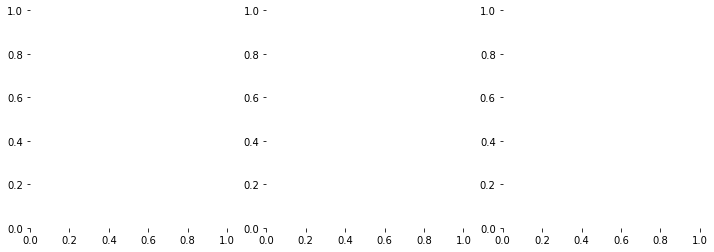

In [ ]:
if viz:
    makedirs('png')
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(12, 4), facecolor='white')
    ax_traj = fig.add_subplot(131, frameon=False)
    ax_phase = fig.add_subplot(132, frameon=False)
    ax_vecfield = fig.add_subplot(133, frameon=False)
    plt.show(block=False)

In [ ]:
plot_x_lim = 3
plot_y_lim = 3

def visualize(true_y, pred_y, odefunc, itr, batch_y, batch_t):

    if viz:

        ax_traj.cla()
        ax_traj.set_title('Trajectories')
        ax_traj.set_xlabel('t')
        ax_traj.set_ylabel('x,y')
        ax_traj.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 0], t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 1], 'g-')
        ax_traj.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 0], '--', t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 1], 'b--')
        ax_traj.set_xlim(t.cpu().min(), t.cpu().max())
        ax_traj.set_ylim(0, plot_x_lim)
       #ax_traj.legend()

        ax_phase.cla()
        ax_phase.set_title('Phase Portrait')
        ax_phase.set_xlabel('x')
        ax_phase.set_ylabel('y')
        ax_phase.plot(true_y.cpu().numpy()[:, 0, 0], true_y.cpu().numpy()[:, 0, 1], 'g-')
        ax_phase.plot(pred_y.cpu().numpy()[:, 0, 0], pred_y.cpu().numpy()[:, 0, 1], 'b--')
        ax_phase.plot(batch_y0.cpu().numpy()[:, 0, 0], batch_y0.cpu().numpy()[:, 0, 1], 'r*')
        ax_phase.set_xlim(0, plot_x_lim)
        ax_phase.set_ylim(0, plot_y_lim)

        ax_vecfield.cla()
        ax_vecfield.set_title('Learned Vector Field')
        ax_vecfield.set_xlabel('x')
        ax_vecfield.set_ylabel('y')

        y, x = np.mgrid[0:plot_x_lim:21j, 0:plot_y_lim:21j]
        dydt = odefunc(0, torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 2)).to(device)).cpu().detach().numpy()
        mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
        dydt = (dydt / mag)
        dydt = dydt.reshape(21, 21, 2)

        ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")
        ax_vecfield.set_xlim(0,plot_x_lim)
        ax_vecfield.set_ylim(0,plot_y_lim)

        fig.tight_layout()
        fig.savefig('png/{:03d}'.format(itr))
        fig.show()
        #plt.draw()
        #plt.pause(0.001)

In [ ]:
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)

In [ ]:
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

In [ ]:
ii = 0

func = ODEFunc().to(device)
#optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
end = time.time()

time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)
learnrate = 1e-3
loss_array = []
for itr in range(1, niters + 1):
    optim.RMSprop(func.parameters(), lr=learnrate).zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0, batch_t).to(device)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    learnrate = 1e-5 if loss.item()<.1 else 1e-3
    loss.backward()
    optim.RMSprop(func.parameters(), lr=learnrate).step()

    time_meter.update(time.time() - end)
    loss_meter.update(loss.item())
    if itr % test_freq == 0:
        with torch.no_grad():
            pred_y = odeint(func, true_y0, t)
            loss = torch.mean(torch.abs(pred_y - true_y))
            loss_array.append(loss.item())
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            visualize(true_y, pred_y, func, ii, batch_y0, batch_t)
            ii += 1
    end = time.time()

Iter 0010 | Total Loss 0.683633
Iter 0020 | Total Loss 0.631209
Iter 0030 | Total Loss 0.573477
Iter 0040 | Total Loss 0.441306
Iter 0050 | Total Loss 0.434184
Iter 0060 | Total Loss 0.319315
Iter 0070 | Total Loss 0.315001
Iter 0080 | Total Loss 0.313486
Iter 0090 | Total Loss 0.292455
Iter 0100 | Total Loss 0.242980
Iter 0110 | Total Loss 0.308283
Iter 0120 | Total Loss 0.303338
Iter 0130 | Total Loss 0.195814
Iter 0140 | Total Loss 0.213389
Iter 0150 | Total Loss 0.215220
Iter 0160 | Total Loss 0.235605
Iter 0170 | Total Loss 0.233116
Iter 0180 | Total Loss 0.230946
Iter 0190 | Total Loss 0.233049
Iter 0200 | Total Loss 0.169887
Iter 0210 | Total Loss 0.167867
Iter 0220 | Total Loss 0.166700
Iter 0230 | Total Loss 0.167922
Iter 0240 | Total Loss 0.169443
Iter 0250 | Total Loss 0.171538
Iter 0260 | Total Loss 0.175003
Iter 0270 | Total Loss 0.177801
Iter 0280 | Total Loss 0.182396
Iter 0290 | Total Loss 0.186015
Iter 0300 | Total Loss 0.186767
Iter 0310 | Total Loss 0.196445
Iter 032

Text(0, 0.5, 'loss')

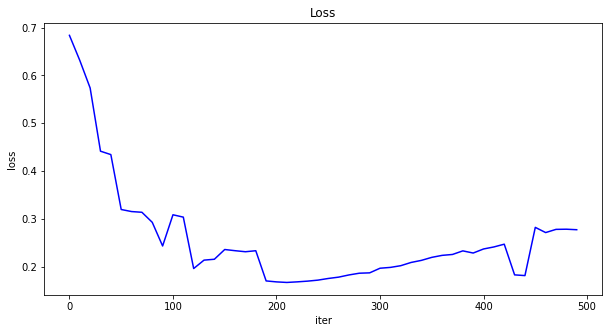

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(0,len(loss_array))*test_freq,loss_array,'-b')
plt.title('Loss')
plt.xlabel('iter')
plt.ylabel('loss')

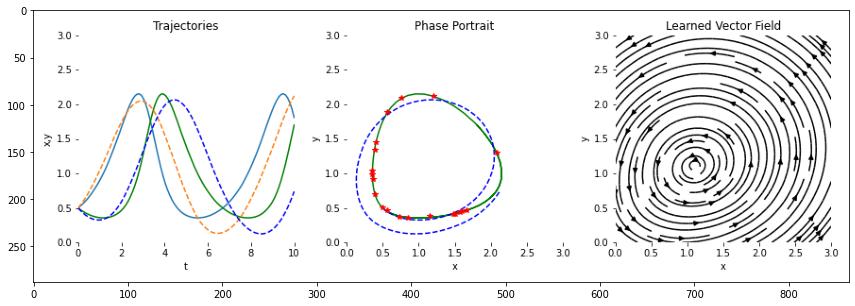

In [ ]:
plt.figure(figsize=(15,5))
plt.imshow(plt.imread('/content/png/047.png'))

In [ ]:
!ls png/
!zip -r /content/png.zip /content/png

000.png  006.png  012.png  018.png  024.png  030.png  036.png  042.png	048.png
001.png  007.png  013.png  019.png  025.png  031.png  037.png  043.png	049.png
002.png  008.png  014.png  020.png  026.png  032.png  038.png  044.png
003.png  009.png  015.png  021.png  027.png  033.png  039.png  045.png
004.png  010.png  016.png  022.png  028.png  034.png  040.png  046.png
005.png  011.png  017.png  023.png  029.png  035.png  041.png  047.png
  adding: content/png/ (stored 0%)
  adding: content/png/017.png (deflated 5%)
  adding: content/png/021.png (deflated 6%)
  adding: content/png/003.png (deflated 6%)
  adding: content/png/038.png (deflated 5%)
  adding: content/png/025.png (deflated 6%)
  adding: content/png/029.png (deflated 6%)
  adding: content/png/043.png (deflated 5%)
  adding: content/png/007.png (deflated 5%)
  adding: content/png/000.png (deflated 6%)
  adding: content/png/006.png (deflated 5%)
  adding: content/png/037.png (deflated 5%)
  adding: content/png/012.png (deflated

# Learned Dynamics

In [ ]:
t = 10
y = torch.Tensor([5,2]).to(device) # y1,y2

dydt_pred = func(t,y).cpu().detach().numpy()

In [ ]:
dydt_pred

array([-0.31739724,  3.137618  ], dtype=float32)

In [ ]:
y0 = torch.tensor([[.5, .5]]).to(device)
t = torch.linspace(0., 10., 5).to(device)

y_pred = odeint(func, y0, t).to(device)

In [ ]:
y_pred

tensor([[[0.5000, 0.5000]],

        [[1.9695, 0.9107]],

        [[0.7152, 1.9447]],

        [[0.3615, 0.3170]],

        [[2.1088, 0.7386]]], grad_fn=<OdeintAdjointMethodBackward>)